# Exercise - Bundesliga Game Prediction with Pyro


## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements) 
  * [Knowledge](#Knowledge)
  * [Modules](#Python-Modules)
* [Exercises](#Exercises)
  * [Loading and Preprocessing of Data](#Loading-and-Preprocessing-of-Data)
  * [Poisson distribution](#Poisson-distribution)
  * [Probabilistic Model](#Probabilistic-Model)
  * [Implementation with PyMC](#Implementation-with-PyMC)
  * [Sampling with PyMC3](#Sampling-with-PyMC3)
  * [Plotting Results](#Plotting-Results)
  * [Expected Winner](#Expected-Winner)
  * [Distribution of Expected Goals](#Distribution-of-Expected-Goals)
  * [Extension of the Model](#Extension-of-the-Model)
  * [Summary and Further Modifications0](#Summary-and-Further-Modifications)
* [Licenses](#Licenses)

## Introduction

In this exercises you will define a simple model for predicting soccer games for the German "Bundesliga" (1st League) based on prior games using Pyro.

Remark: In order to detect errors in your own code, execute the notebook cells containing `assert` or `assert_almost_equal`. These statements raise exceptions, as long as the calculated result is not yet correct.

## Requirements

### Knowledge


To complete this exercise notebook, you should possess knowledge about the following topics.

- Basics of Bayesian Inference, see e.g. [Introduction into Bayesian Inference with PyMc3](http://christianherta.de/lehre/dataScience/bayesian/introduction_into_bayesian_inference_with_pymc.slides.php)
- Knowledge about the Gaussian and Poisson distribution.

### Python Modules

In [8]:
import numpy as np
import pandas as pd
 
import scipy.stats
from scipy.stats import norm

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize


%matplotlib inline

In [9]:
import torch
from torch.distributions import constraints

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101);

## Exercises

We have the data of past "Bundesliga" games (1st soccer league in Germany) from 2017 and 2018. Specifically, each datapoint contains the names of the two teams ("Verein" in german) playing agains each other and the final score. 

One file contains the names of the teams, e.g. the first two lines (and header lines of `bundesliga_Verein.csv`:

```
V_ID;Name;Liga
1;FC Bayern München;1
2;FC Schalke 04;1
...
```

The header line `V_ID;Name;Liga` translates into the columns `team_ID; name, league`

The second file contains ~1.300 games, e.g.:

```
Spiel_ID;Spieltag;Datum;Uhrzeit;Heim;Gast;Tore_Heim;Tore_Gast
1;1;2017-08-18;20:30:00;1;5;3;1
2;1;2017-08-19;15:30:00;7;12;1;0
...
```

The header line here means `game_ID;date_of_play;date;time;home_team_ID,guest_team_ID;score_home_team;score_guest_team`

Based on this data, our goal is to predict the score of upcoming games.

### Loading and Preprocessing of Data 

First we'll loead the data from the corresponding csv-files and do some preprocessing. As the files not only contain games of the 1st league we have to filter them. We do the data loading and preprocessing using the `pandas` library's `dataframe` class.

In [19]:
### Load the data to lookup team-id and corresponding team-name
#url_vereine_csv = "https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/notebooks/data/bundesliga_Verein.csv"
### Alternative URL:
url_vereine_csv = "https://github.com/hsro-wif-prg2/hsro-wif-prg2.github.io/raw/master/examples/src/main/resources/bundesliga_Verein.csv"
clubs = pd.read_csv(url_vereine_csv, sep=';')

In [20]:

### for convinience the club id should start with 0
clubs.V_ID = clubs.V_ID - 1
clubs = clubs.set_index("V_ID")

### just 1. league 
club_ids = clubs[clubs.Liga==1].index
club_ids

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], dtype='int64', name='V_ID')

In [23]:
### Now load the data about past games from 2017 and 2018
#url_spiele_csv = "https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/notebooks/data/bundesliga_Spiel.csv"
### Alternative URL:
url_spiele_csv = "https://github.com/hsro-wif-prg2/hsro-wif-prg2.github.io/raw/master/examples/src/main/resources/bundesliga_Spiel.csv"
games = pd.read_csv(url_spiele_csv, sep=';')

#del(games["Unnamed: 8"]) ### not existent anymore?

### for convinience the club id should start with 0
games.Heim = games.Heim-1
games.Gast = games.Gast-1

In [24]:
### Filter for games of teams in 1st league
relevant_games = games[games.Heim.isin(club_ids)]

### Have a look at the data
relevant_games

Spiel_ID  Spieltag       Datum   Uhrzeit  Heim  Gast  Tore_Heim  \
0           1         1  2017-08-18  20:30:00     0     4          3   
1           2         1  2017-08-19  15:30:00     6    11          1   
2           3         1  2017-08-19  15:30:00    14     2          0   
3           4         1  2017-08-19  15:30:00    10     7          2   
4           5         1  2017-08-19  15:30:00    17     9          1   
..        ...       ...         ...       ...   ...   ...        ...   
634      1356        32  2018-04-28  15:30:00    13    16          3   
635      1357        32  2018-04-28  15:30:00    14    17          1   
636      1358        32  2018-04-28  18:30:00     4     7          0   
637      1359        32  2018-04-29  15:30:00    15     3          3   
638      1360        32  2018-04-29  18:00:00    11     2          1   

     Tore_Gast  
0            1  
1            0  
2            3  
3            0  
4            0  
..         ...  
634          2  
635          3  
636          1  
637          0  
638          1  

[288 rows x 8 columns]

In [25]:
### We'll use the games from 2017 for training the model
actual_date = "2018-01-01"
relevant_games = relevant_games[games.Datum < actual_date]
print('Size of training set: ', len(relevant_games))

Size of training set:  153


<ipython-input-25-24a3c2a33cd4>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_games = relevant_games[games.Datum < actual_date]


In [26]:
def get_goal_results(gh="Tore_Gast"):
    result = list()
    for i in relevant_games.iterrows():
        r = i[1]
        result.append((r.Heim, r.Gast, r[gh]))
    return result

away_goals_ = get_goal_results("Tore_Gast")
home_goals_ = get_goal_results("Tore_Heim")

In [27]:
### We are not interested in date and time data,
### so we extract only team ids and score:

def get_goal_results(gh="Tore_Gast"):
    result = list()
    for i in relevant_games.iterrows():
        ### index 0 contains pandas-dataframe id, 
        ### which we are not interested in.
        r = i[1]
        result.append((r.Heim, r.Gast, r[gh]))
    return result

### Lists of tuples
away_goals_ = get_goal_results("Tore_Gast")
home_goals_ = get_goal_results("Tore_Heim")

### Print one example
print('First tuple of list \'away_goals_\':')
print('(id_home, id_guest, goals_guest)')
print(away_goals_[0])

print('\nFirst tuple of list \'away_goals_\':')
print('(id_home, id_guest, goals_home)')
print(home_goals_[0])

First tuple of list 'away_goals_':
(id_home, id_guest, goals_guest)
(0, 4, 1)

First tuple of list 'away_goals_':
(id_home, id_guest, goals_home)
(0, 4, 3)


### Poisson distribution

As the number of goals $k$ a team scores is not continous but a discrete value, it can be modeled with a Poisson distribution $P_\lambda (k)$:

Probability for outcome $k \in \{0, 1, 2, \dots\}$
 
$$
P_\lambda (Z=k) = \frac{\lambda^k}{k!}\, \mathrm{e}^{-\lambda}
$$

with parameter $\lambda>0$

**Notes:**
- If a random variable $Z$ has a Poisson mass distribution, we denote this by writing

$$Z \sim \text{Poi}(\lambda) $$

- $\lambda$ is also the expectation and variance of the Poisson distribution

$$E\left[ \;Z\; | \; \lambda \;\right] = \sigma^2 \left[ \;Z\; | \; \lambda \; \right] = \lambda $$

- PMFs (probability mass functions) for discrete variables sum up to $1.0$

### Graphical Representation of the Model

In [28]:
import daft
def plot_model():
    pgm = daft.PGM([6.3, 4.05], origin=[-1., -1.])
    pgm.add_node(daft.Node("mu_o", r"$\mu_o$", .5, .5, fixed=True))
    pgm.add_node(daft.Node("tau_o", r"$\tau_o$", .5, 1.5, fixed=True))    
    pgm.add_node(daft.Node("o_i", r"o$_i$", 1.5, 1))
    
    pgm.add_node(daft.Node("tau_d", r"$\tau_d$", 2., 3., fixed=True))
    pgm.add_node(daft.Node("mu_d", r"$\mu_d$", 3., 3., fixed=True))
    pgm.add_node(daft.Node("d_j", r"d$_j$", 2.5, 2.2))
    
    pgm.add_node(daft.Node("g", r"g$_{ij}$", 2.5, 1., observed=True))

    
    # Add in the edges.
    pgm.add_edge("mu_o", "o_i")
    pgm.add_edge("tau_o", "o_i")
    pgm.add_edge("mu_d", "d_j")
    pgm.add_edge("tau_d", "d_j")
    pgm.add_edge("o_i", "g")
    pgm.add_edge("d_j", "g")
    # And plates.
    pgm.add_plate(daft.Plate([2., 0.2, 1., 2.5], label=r"$j$", shift=0.))
    pgm.add_plate(daft.Plate([1., 0.5, 2.2, 1.1], label=r"$i$", shift=0.))
    pgm.render()

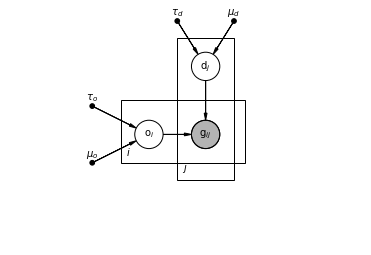

In [29]:
plot_model()

### Implementation with Pyro

Let us define the model with Pyro:
- First we define our normal distributions for offence strengths and defence strengths (one for **each** team)

For eacht tuple in `home_goals_`:
- We iterate through our list of tuples `home_goals_`
- Doing this we generate a list of goals scored at home
- We also generate a list for the `home_rate`, which is a result of offence-defence.
- Afterwards we define the poisson distribution with goals scored and the mean
  
**Task:**

Below you see the code to iterate through the list `home_goals_`. Your task is to add the code to do the same for `away_goals_`.

In [30]:
### Number of clubs
nb_clubs = len(club_ids)

### offence-defence could be negative, but number of goals scored cannot.
### When dealing with distributions for continous variables, 
### e.g. gaussian (normal), theres never probability of exactly 0,
### so for zero we'll use something very small instead
low_ = 1e-10

In [31]:
def model_games(home_goals_, away_goals_, nb_clubs = nb_clubs, prior_diff=1.5):
    assert len(home_goals_) == len(away_goals_)
    nb_games= len(home_goals_)
   
    mu_offence_prior = torch.zeros(nb_clubs) + prior_diff
    mu_defence_prior = torch.zeros(nb_clubs)
    sigma_offence_prior = torch.ones(nb_clubs)
    sigma_defence_prior = torch.ones(nb_clubs)
    
    offence = pyro.sample("offence", dist.Normal(mu_offence_prior, sigma_offence_prior)) 
    defence = pyro.sample("defence", dist.Normal(mu_defence_prior, sigma_defence_prior))
    
    ### data
    home_goals = []
    # this must be a torch tensor (for backprop!!!)
    home_rates = torch.zeros(nb_games) 
    
    ### HOME
    for i, (heim, gast, goals) in enumerate(home_goals_):
        home_rate = offence[heim] - defence[gast]
        if home_rate < low_:
            home_rate = low_
        home_goals.append(goals)
        home_rates[i] = home_rate
    home_goals = torch.tensor(home_goals, dtype=torch.float32)
    
    with pyro.plate('observe_data', size=nb_games, subsample_size=100) as ind:   
        pyro.sample("home_goals", dist.Poisson(home_rates.index_select(0, ind)), obs=home_goals.index_select(0, ind))
   
    ### AWAY
    
    ######################
    ### YOUR CODE HERE ###
    ######################

    return offence, defence

In [33]:
def guide_games(home_goals_, away_goals_, nb_clubs = nb_clubs, prior_diff=1.5):
    # register the  variational parameters with Pyro.   
    mu_offence = pyro.param("mu_offence", torch.zeros(nb_clubs) + prior_diff)
    mu_defence = pyro.param("mu_defence", torch.zeros(nb_clubs))
    sigma_offence = pyro.param("sigma_offence", torch.ones(nb_clubs)*2.)
    sigma_defence = pyro.param("sigma_defence", torch.ones(nb_clubs)*2.)
        
    offence = pyro.sample("offence", dist.Normal(mu_offence, sigma_offence)) 
    defence = pyro.sample("defence", dist.Normal(mu_defence, sigma_defence))
    #print(mu_offence)
    return offence, defence

### Inference with Pyro

Now we can simple infere the parameters of our model.

In [34]:
pyro.clear_param_store()

adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
from pyro.optim import Adam
optimizer = Adam(adam_params)

svi = pyro.infer.SVI(model=model_games,
                     guide=guide_games,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())


In [35]:
losses = []
for t in range(10000):
    loss = svi.step(home_goals_, away_goals_)
    losses.append(loss)
    if t%100==0:
        print (t, "\t", loss)

0 	 2631.8974800109863
100 	 2896.5082244873047
200 	 2375.434253692627
300 	 2762.044828414917
400 	 1558.6472759246826
500 	 1451.141918182373
600 	 1777.1866149902344
700 	 1826.477611541748
800 	 1227.7646942138672
900 	 2053.0084323883057
1000 	 1702.8256168365479
1100 	 802.3045082092285
1200 	 1437.515468597412
1300 	 1152.2613372802734
1400 	 808.1425132751465
1500 	 778.383222579956
1600 	 567.4989147186279
1700 	 587.0614461898804
1800 	 713.5388164520264
1900 	 912.3588676452637
2000 	 593.9784278869629
2100 	 646.4124736785889
2200 	 919.5878467559814
2300 	 650.4728441238403
2400 	 576.0012550354004
2500 	 650.3751430511475
2600 	 974.0084819793701
2700 	 715.9623413085938
2800 	 533.5556282997131
2900 	 731.7692041397095
3000 	 784.656551361084
3100 	 528.9434604644775
3200 	 526.3452062606812
3300 	 487.27504539489746
3400 	 535.1392388343811
3500 	 549.4360876083374
3600 	 631.432671546936
3700 	 519.1862411499023
3800 	 518.7940149307251
3900 	 513.3840997219086
4000 	

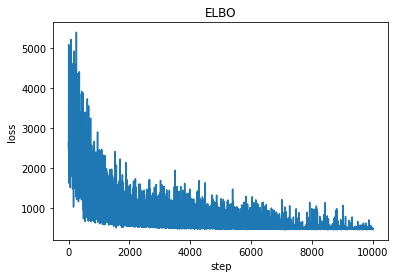

In [36]:
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

The first thing we could do is to get the mean offence and defence strength of for the individual teams. If your code so far is correct the output of the following two cells should look similar to the following:

```
Mean offence strength per team:
FC Bayern München   2.125811790340167
FC Schalke 04   1.7037162684586846
Borussia Dortmund   2.257390525324742
RB Leipzig   1.6020905056271877
Bayer Leverkusen   2.0050107075685344
...
```

```
Mean defence strength per team:
FC Bayern München   0.7821524828924918
FC Schalke 04   0.054772520741117325
Borussia Dortmund   -0.06449457068251914
RB Leipzig   -0.006551429185531419
Bayer Leverkusen   0.06109513176503763
...
```


In [37]:
# grab the learned variational parameters
mu_offence_param = pyro.param("mu_offence").data
mu_defence_param = pyro.param("mu_defence").data
sigma_offence_param = pyro.param("sigma_offence").data
sigma_defence_param = pyro.param("sigma_defence").data

In [55]:
clubs.values[1][0]

'FC Schalke 04'

In [58]:
print('Mean offence strenght per team: \n')
for i, mu in enumerate(mu_offence_param):
    #print (clubs.get_value(i, "Name"), ": ", float(mu))
    print (clubs.values[i][0],": ", float(mu))

Mean offence strenght per team: 

FC Bayern München :  2.085266590118408
FC Schalke 04 :  1.619349718093872
Borussia Dortmund :  2.2389016151428223
RB Leipzig :  1.5229805707931519
Bayer Leverkusen :  1.8728883266448975
Eintracht Frankfurt :  1.1861600875854492
1899 Hoffenheim :  1.5919101238250732
VfB Stuttgart :  0.7459101676940918
Borussia Mönchengladbach :  1.649450659751892
FC Augsburg :  1.509215235710144
Hertha BSC :  1.8690078258514404
SV Werder Bremen :  0.7754116058349609
Hannover 96 :  2.047071695327759
SC Freiburg :  0.9519020915031433
VfL Wolfsburg :  1.3230311870574951
1. FSV Mainz 05 :  1.2153500318527222
1. FC Köln :  0.7669610381126404
Hamburger SV :  0.8723775744438171


In [59]:
print('Mean defence strenght per team:')
for i, mu in enumerate(mu_defence_param):
#    print (clubs.get_value(i, "Name"), ": ", float(mu))
    print (clubs.values[i][0],": ", float(mu))

Mean defence strenght per team:
FC Bayern München :  0.6516261696815491
FC Schalke 04 :  -0.01707650162279606
Borussia Dortmund :  -0.2981777787208557
RB Leipzig :  -0.09655066579580307
Bayer Leverkusen :  -0.20306487381458282
Eintracht Frankfurt :  0.06219616159796715
1899 Hoffenheim :  -0.1007412001490593
VfB Stuttgart :  -0.09203644096851349
Borussia Mönchengladbach :  -0.1700153946876526
FC Augsburg :  -0.06935661286115646
Hertha BSC :  -0.1174454540014267
SV Werder Bremen :  0.1536731719970703
Hannover 96 :  -0.27776461839675903
SC Freiburg :  -0.4957292377948761
VfL Wolfsburg :  0.0016517814947292209
1. FSV Mainz 05 :  -0.35094866156578064
1. FC Köln :  -0.5526672601699829
Hamburger SV :  -0.27699825167655945


Of course we can also get the standard deviation $\sigma$:

In [60]:
print('STD of offence strenght per team:')
for i, s in enumerate(sigma_offence_param):
    print (clubs.values[i][0],": ", float(s))
    #print (clubs.get_value(i, "Name"), ": ", float(s))

STD of offence strenght per team:
FC Bayern München :  0.4347163438796997
FC Schalke 04 :  0.27529528737068176
Borussia Dortmund :  0.3126586079597473
RB Leipzig :  0.20191240310668945
Bayer Leverkusen :  0.30809956789016724
Eintracht Frankfurt :  0.23068274557590485
1899 Hoffenheim :  0.26343488693237305
VfB Stuttgart :  0.15126308798789978
Borussia Mönchengladbach :  0.2682895064353943
FC Augsburg :  0.2768387794494629
Hertha BSC :  0.44573259353637695
SV Werder Bremen :  0.19791270792484283
Hannover 96 :  0.6752307415008545
SC Freiburg :  0.22413454949855804
VfL Wolfsburg :  0.2105192095041275
1. FSV Mainz 05 :  0.18501411378383636
1. FC Köln :  0.08621078729629517
Hamburger SV :  0.19638778269290924


In [62]:
print('STD of defence strenght per team:')
for i, s in enumerate(sigma_defence_param):
#    print (clubs.get_value(i, "Name"), ": ", float(s))
    print (clubs.values[i][0],": ", float(s))

STD of defence strenght per team:
FC Bayern München :  0.18633413314819336
FC Schalke 04 :  0.224699005484581
Borussia Dortmund :  0.2805652618408203
RB Leipzig :  0.2280290424823761
Bayer Leverkusen :  0.11619468033313751
Eintracht Frankfurt :  0.17321784794330597
1899 Hoffenheim :  0.2125217765569687
VfB Stuttgart :  0.21491581201553345
Borussia Mönchengladbach :  0.2513063848018646
FC Augsburg :  0.2349672019481659
Hertha BSC :  0.2537551820278168
SV Werder Bremen :  0.20672377943992615
Hannover 96 :  0.25029256939888
SC Freiburg :  0.28620678186416626
VfL Wolfsburg :  0.21176809072494507
1. FSV Mainz 05 :  0.2671497166156769
1. FC Köln :  0.31045660376548767
Hamburger SV :  0.12072864919900894


### Plotting Results

Combining the mean $\mu$ and standard deviation $\sigma$, we can now plot the posterior normal distributions.

The plot should look similar to the following (only the first 3 are here shown as picture):


![internet connection needed](https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/klaus/bundesliga_pdf_pyro.png)


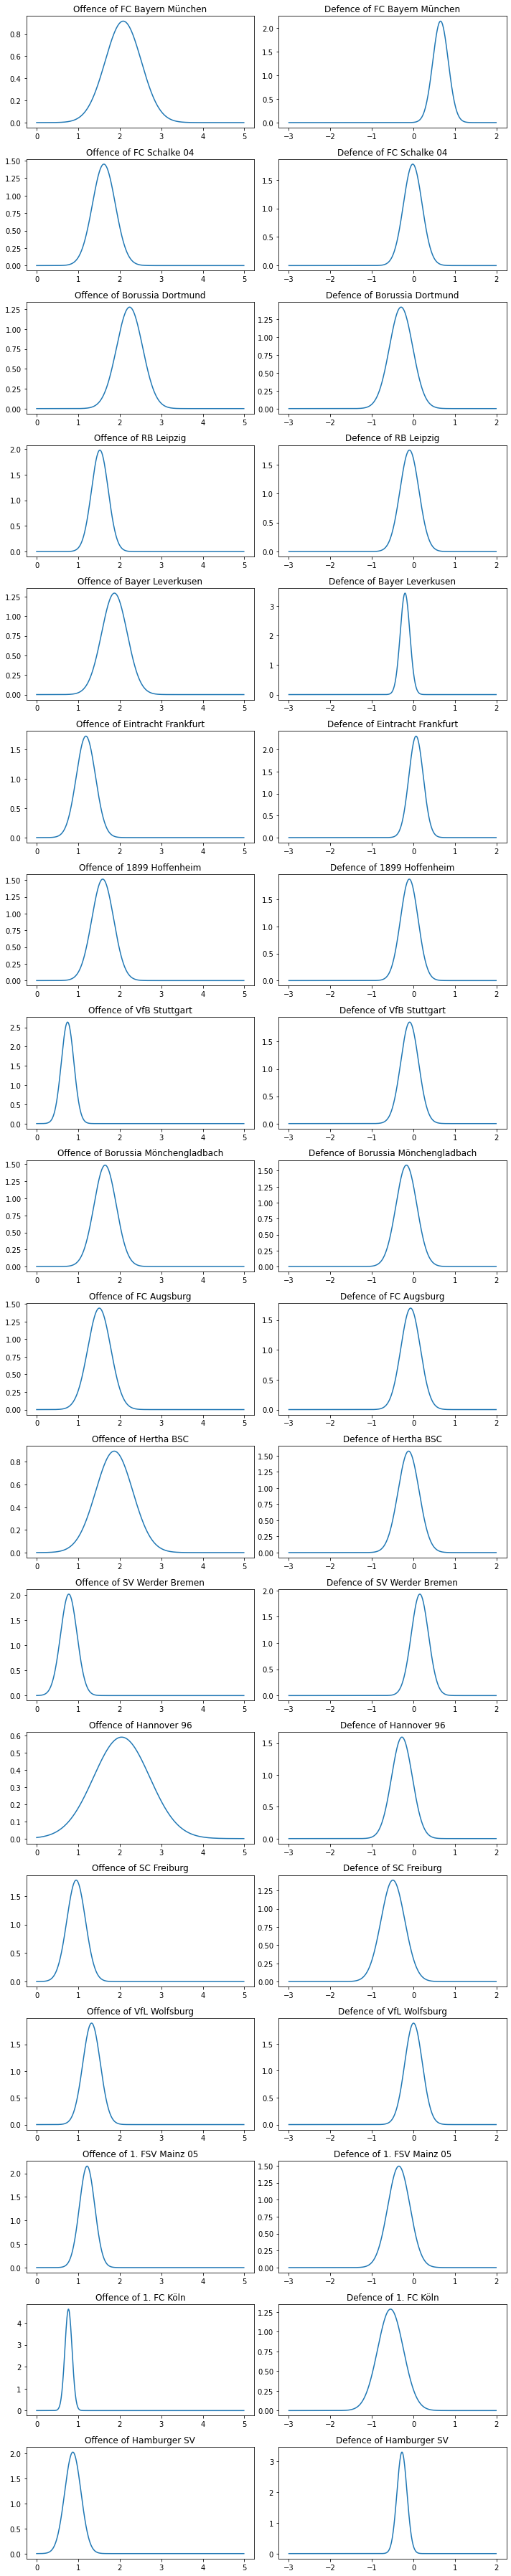

In [64]:
nb_clubs = club_ids.max() + 1
bins=40
fig, axes = plt.subplots(nrows=nb_clubs, ncols=2, figsize=(10, 50))
x_offence = np.arange(0,5,0.01)
x_defence = np.arange(-3,2,0.01)
for i in club_ids: 
    title = "Offence of " + clubs[clubs.index==i]["Name"][i]
    axes[i, 0].set_title(title)   
    axes[i, 0].plot(x_offence, norm.pdf(x_offence, mu_offence_param[i], sigma_offence_param[i]))
    
    axes[i, 1].plot(x_defence, norm.pdf(x_defence, mu_defence_param[i], sigma_defence_param[i]))
    title = "Defence of " + clubs[clubs.index==i]["Name"][i]
    axes[i, 1].set_title(title)

#fig.suptitle("Offence and defence distribution of the clubs.")
fig.subplots_adjust(hspace=0.5)
fig.tight_layout()

### Expected Winner

**Task:**

Use the model for an estimate the probability that team 1 wins again team 2 (or a tie)?

Implement the function `get_probs_winner(id_team1, id_team2)`.


**Hint:**

Use sampling from the (variational) probability densities:

* First implement `get_diffs(team_i, team_j)` which calculates:
  * $diff_{ij} = offence_i-defence_j$
  * And $diff_{ji} = offence_j-defence_i$
  * Example output:
      * ```python
        goals_ij, goals_ji = get_diffs(0, 17)
        print('diff 1:')
        print(goals_ij, goals_ij.shape)
        print('diff 2:')
        print(goals_ji, goals_ji.shape)
      ```
      ```
        diff 1:
        [1.56857698 2.07895304 2.04293421 ... 2.22588423 2.08634941 2.20760956] (4000,)
        diff 2:
        [0.1226164  0.0446999  0.78191971 ... 0.29486617 0.50708817 0.3921155 ] (4000,)
        ```

* Second, implement `get_probs_winner(team1, team2)`, which uses `get_diffs(team_i, team_j)` inside:
  * Sample from a poisson distribution the number of goals for each value in $diff_{ij}$ and each value in $diff_{ji}$ to get the number of goals scored:
    * $goals_{ij} = Poisson \left(\lambda = (diff_{ij}) \right)$
    * $goals_{ji} = Poisson \left(\lambda = (diff_{ji}) \right)$
  * Then compare the each $goals_{ij}$ an $goals_{ji}$.
  * Example output:
    * ```python
        get_probs_winner(0, 17)
        ```
        ```
        FC Bayern München : Hamburger SV
        (prob team1, prob team2, tie)
        (0.80625, 0.03675, 0.157)
        ```
        
All functions you need were already presented in this notebook, e.g.:
 * `pyro.param("mu_offence").data` and `pyro.param("sigma_offence").data` for example in conjuction with `np.random.normal(mu, sigma)` to draw samples from a Gaussian and ...
 * `scipy.stats.poisson.pmf(k, lambda_)` or `np.random.poisson(lambda_)` to sample from Poisson.

In [65]:
def get_diffs(team_1, team_2):
    
    raise NotImplementedError()
    
    return diff_ij, diff_ji

In [67]:
diff_ij, diff_ji = get_diffs(0, 17)
print('diff 1:')
print(diff_ij, diff_ij.shape)
print('diff 2:')
print(diff_ji, diff_ji.shape)

diff 1:
[3.67648569 1.81703187 2.67985107 ... 2.66214782 3.06589433 2.98089422] (4000,)
diff 2:
[-1.01014121  0.83204188 -0.02999159 ...  0.12567738 -0.61003284
  0.94448131] (4000,)


In [68]:
def get_probs_winner(team1, team2):
    print (clubs.at[team1, "Name"],":",clubs.at[team2, "Name"])

    raise NotImplementedError()
    
    print('(prob team1, prob team2, tie)')
    return p1, p2, tie

In [73]:
get_probs_winner(0, 17)

FC Bayern München : Hamburger SV
(prob team1, prob team2, tie)


(0.806, 0.05075, 0.14325)

### Distribution of Expected Goals

**Task:**

Use the model and the sampling trace to predict how many goals a teams scores agains another team.

What is the expected number of the goals each team scores?  

Implement the corresponding python (plot) functions.

For team with index 0 (Bayern München) vs . team with index 17 (Hamburg), the plot (a poisson distribution) should look similar to the follwowing:

![internet connection needed](https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/klaus/bundesliga_fcb_vs_hamburg.png)

**Hints:**


* Implement `get_goal_distribution(diff, max_goals=20)` which:
  * takes as input parameter one of the outputs of `get_diffs(team_i, team_j)`
  * and outputs poisson distribution for the probabilities that the corresponing team scored 0, 1, ..., or `max_goals`:
  * $goals_{ij} = Poisson \left(\lambda = (diff_{ij}) \right)$
  * example output: 
      * ```python
        poisson_goals_1 = get_goal_distribution(diff_ij)
        print('poisson_goals_1 1:')
        print(poisson_goals_1)
      ```
      ```
        poisson_goals_1 1:
        [1.85886410e-01 2.99635677e-01 2.54125262e-01 1.50583060e-01
        6.99165158e-02 2.70688509e-02 9.08722901e-03 2.71762207e-03
        7.38568964e-04 1.85245582e-04 4.34180830e-05 9.60812360e-06
        2.02488505e-06 4.09324980e-07 7.98263618e-08 1.50845350e-08
        2.77028983e-09 4.95305584e-10 8.62693285e-11 1.46354975e-11]
      ```
* Implement `plot_goal_diffs(team_1, team_2)`:
  * combines the two functions `get_diffs(team_i, team_j)` and `get_goal_distribution(diff, max_goals=20)` and plots the distributions, shown in the cell above.

In [74]:
def get_goal_distribution(diff, max_goals=20):
    
    raise NotImplementedError()
    
    return poisson_goals

In [76]:
poisson_goals_1 = get_goal_distribution(diff_ij)
print('poisson_goals_1 1:')
print(poisson_goals_1)
poisson_goals_2 = get_goal_distribution(diff_ji)
print('poisson_goals_2 2:')
print(poisson_goals_2)

poisson_goals_1 1:
[1.13498264e-01 2.25782428e-01 2.45812211e-01 1.91080408e-01
 1.17912888e-01 6.11491577e-02 2.76126472e-02 1.11219750e-02
 4.06583983e-03 1.36666813e-03 4.26655110e-04 1.24687246e-04
 3.43275892e-05 8.94887593e-06 2.21834807e-06 5.24751962e-07
 1.18804300e-07 2.58088915e-08 5.39168281e-09 1.08526893e-09]
poisson_goals_2 2:
[7.41184677e-01 1.72435838e-01 6.10904792e-02 1.86374402e-02
 5.05616525e-03 1.24253829e-03 2.80213563e-04 5.86082319e-05
 1.14746015e-05 2.11991262e-06 3.72033959e-07 6.23355363e-08
 1.00070174e-08 1.54248104e-09 2.28532729e-10 3.25571718e-11
 4.45964479e-12 5.87264772e-13 7.43336882e-14 9.04375447e-15]


In [78]:
def plot_goal_diffs(team_1, team_2):
    
    raise NotImplementedError()
    

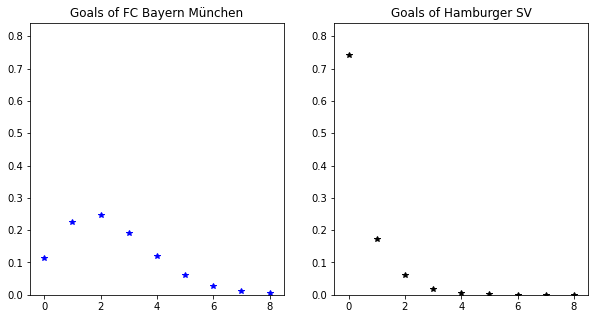

In [80]:
# probability that team 0 scores 0,1,2, ... goals against team 8
plot_goal_diffs(0, 17)

### Extension of the Model

**Task:**

Extend the model with _home advantage_:

At home a team is in general a little bit stronger as away. 
Modify the model to take this into account. This could e.g. be modeled with another normal distribution:

for home games:
$$
goals_{ij} = Poisson \left(\lambda = (offence_i-defence_j + \frac{advantage}{2}) \right)
$$

and games as guest:
$$
goals_{ij} = Poisson \left(\lambda = (offence_i-defence_j - \frac{advantage}{2}) \right)
$$

And plot the posterior home advantage distribution:

![internet connection needed](https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/klaus/bundesliga_posterior_advantage_pyro.png)

**Notes:**
* Note there is no index $i$ or $j$ at the PDF $advantage$. For now it is eassier to assume there is a general advantage which is equal for all teams.

In [89]:
######################
### YOUR CODE HERE ###
######################



### Summary and Further Modifications

In this exercise you modeled a real world scenario with a bayesian model and pyro. Remember that this was just one way of modelling the real world scenario, our model could also have been totally different.

A further extension for example could be to include not a single _home advange_ distribution, but one for each team (like we also modeled individual offence and defence strenghts). Or you could also add individual _away disadvantes_.

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Exercise - Bundesliga Game Prediction with Pyro
by Christian Herta, Klaus Strohmenger<br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 Christian Herta, Klaus Strohmenger

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.